In [1]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
from keras.models import Sequential, Model
from keras_uncertainty.layers import StochasticDropout, SamplingSoftmax
from keras_uncertainty.models import DisentangledStochasticClassifier, StochasticClassifier
from keras.layers import Dense, Input, Dropout
from keras_uncertainty.utils import numpy_entropy

import seaborn as sns


def uncertainty(probs):
    return numpy_entropy(probs, axis=-1)


X, y = make_moons(n_samples=1000, noise=0.1, random_state=0)
BATCH_SIZE = 256
NUM_SAMPLES = 50

Keras Uncertainty will use standalone Keras backend

In [2]:
from disentanglement.models.information_theoretic_models import train_it_model, expected_entropy, mutual_information
from disentanglement.models.gaussian_logits_models import train_gaussian_logits_model
from disentanglement.models.architectures import get_blobs_dropout_architecture

it_ensemble_model = train_it_model(get_blobs_dropout_architecture, X, y, n_classes=2, epochs=100)
gl_ensemble_model = train_gaussian_logits_model(get_blobs_dropout_architecture, X, y, n_classes=2, epochs=100)


/Users/ivopascal/.local/share/virtualenvs/uq_disentanglement_comparison-mONOvMcl/lib/python3.11/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


Choosing from all possible events
/Users/ivopascal/.local/share/virtualenvs/uq_disentanglement_comparison-mONOvMcl/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:394: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return func(X, **(kw_args if kw_args else {}))
/Users/ivopascal/.local/share/virtualenvs/uq_disentanglement_comparison-mONOvMcl/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:394: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return func(X, **(kw_args if kw_args else {}))
/Users/ivopascal/.local/share/virtualenvs/uq_disentanglement_comparison-mONOvMcl/lib/python3.11/site-packages/sklearn/preprocessing/_function_transformer.py:394: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy expl

In [3]:
min_x, max_x = [-3, -3] , [3, 3]
res = 0.1

xx, yy = np.meshgrid(np.arange(min_x[0], max_x[0], res), np.arange(min_x[1], max_x[1], res))
domain = np.c_[xx.ravel(), yy.ravel()]

In [4]:
it_preds = it_ensemble_model.predict_samples(domain, num_samples=50, batch_size=128)

it_ale = expected_entropy(it_preds).reshape(xx.shape)
it_epi = mutual_information(it_preds).reshape(xx.shape)


pred_mean, pred_ale_std, pred_epi_std = gl_ensemble_model.predict(domain, batch_size=128, num_samples=50)

gl_ale = uncertainty(pred_ale_std).reshape(xx.shape)
gl_epi = uncertainty(pred_epi_std).reshape(xx.shape)

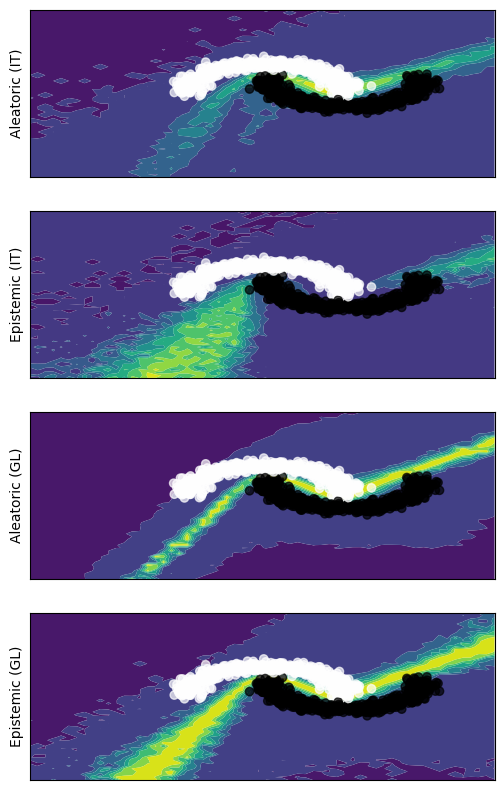

In [5]:
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
sns.reset_orig()

cmap = pl.cm.binary
my_cmap = cmap(np.arange(cmap.N))
#my_cmap[:, 0] = 0.0
my_cmap[:, -1] = 0.7
my_cmap = ListedColormap(my_cmap)


fig, axes =  plt.subplots(ncols=1, nrows=4, figsize=(6, 10), squeeze=False)    
ax_ale_it = axes[0][0]
ax_epi_it = axes[1][0]
ax_ale_gl = axes[2][0]
ax_epi_gl = axes[3][0]

cf_ale = ax_ale_it.contourf(xx, yy, it_ale, antialiased=True)
ax_ale_it.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_ale_it.get_xaxis().set_ticks([])
ax_ale_it.get_yaxis().set_ticks([])
ax_ale_it.autoscale(False)

cf_epi = ax_epi_it.contourf(xx, yy, it_epi, antialiased=True)
ax_epi_it.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_epi_it.get_xaxis().set_ticks([])
ax_epi_it.get_yaxis().set_ticks([])
ax_epi_it.autoscale(False)

ax_ale_it.set_ylabel("Aleatoric (IT)")
ax_epi_it.set_ylabel("Epistemic (IT)") 



cf_ale = ax_ale_gl.contourf(xx, yy, gl_ale, antialiased=True)
ax_ale_gl.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_ale_gl.get_xaxis().set_ticks([])
ax_ale_gl.get_yaxis().set_ticks([])
ax_ale_gl.autoscale(False)

cf_epi = ax_epi_gl.contourf(xx, yy, gl_epi, antialiased=True)
ax_epi_gl.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
ax_epi_gl.get_xaxis().set_ticks([])
ax_epi_gl.get_yaxis().set_ticks([])
ax_epi_gl.autoscale(False)

ax_ale_gl.set_ylabel("Aleatoric (GL)")
ax_epi_gl.set_ylabel("Epistemic (GL)") 



plt.show()

  0%|▋                                                                                                                                                                                                                                                                            | 16/6760 [17:54<116:48:13, 62.35s/it]

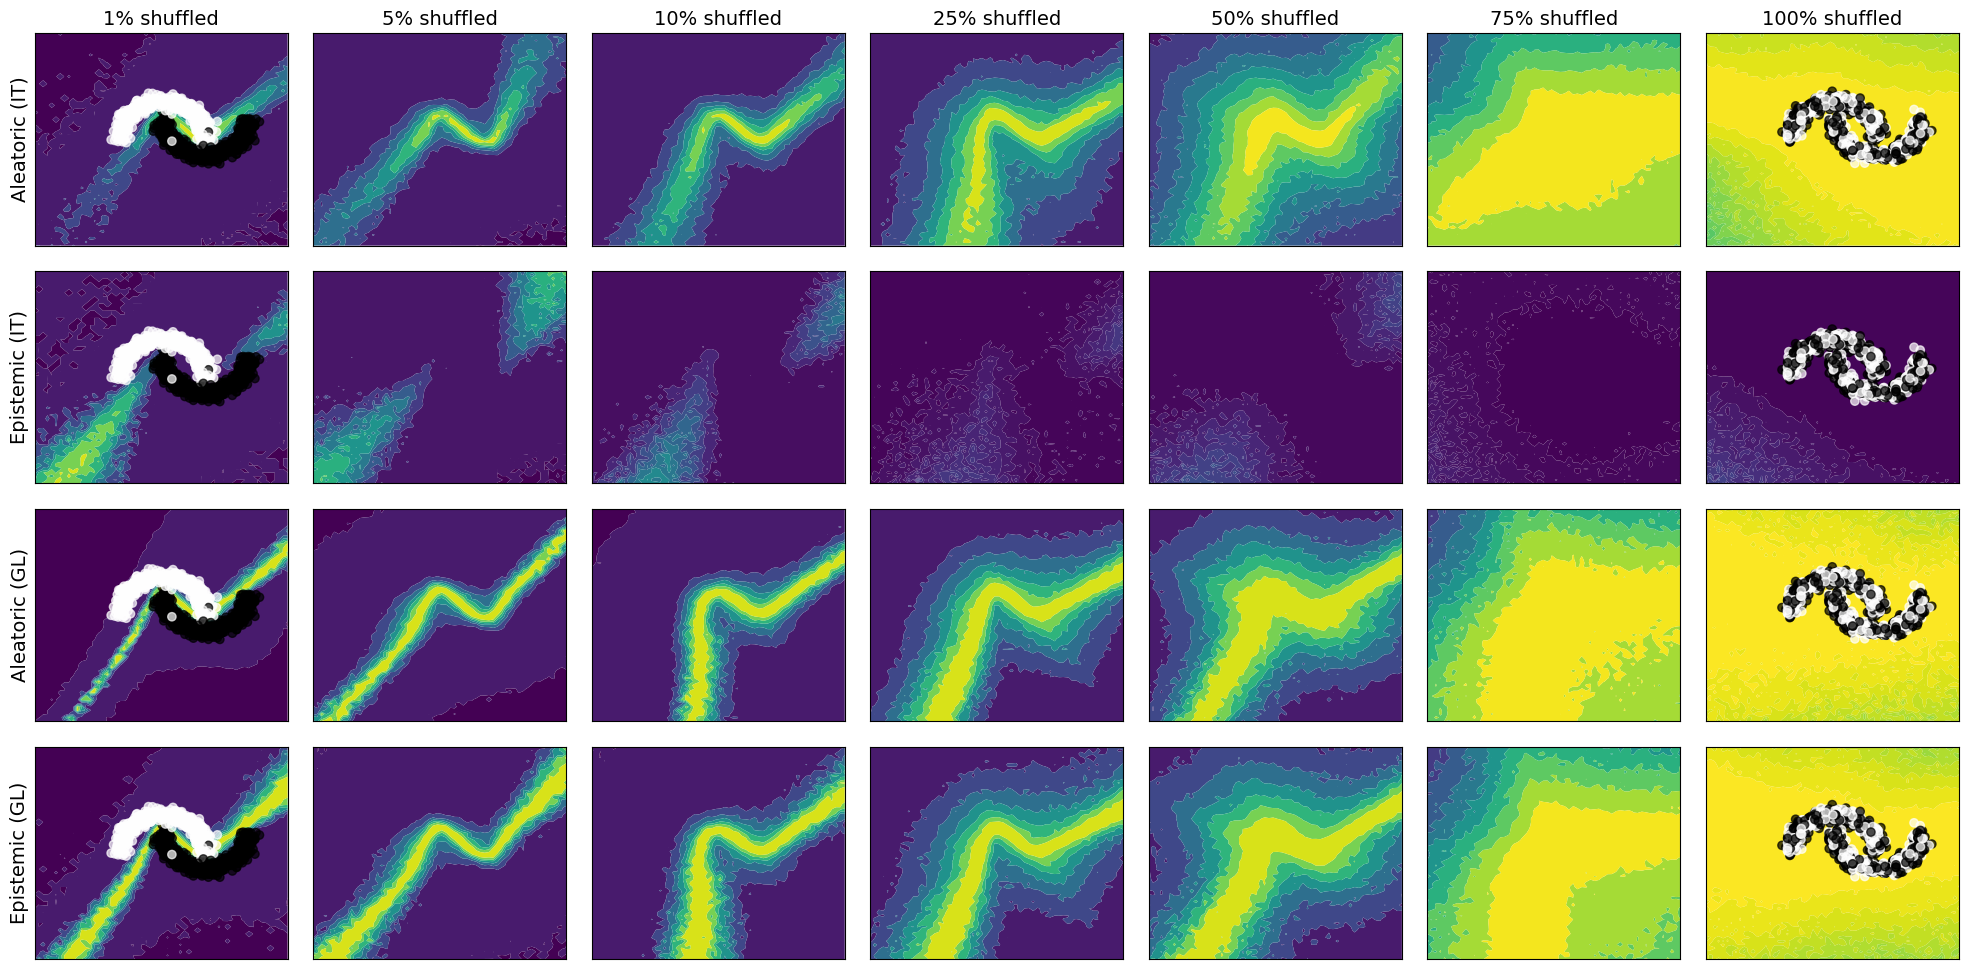

In [6]:
from sklearn.utils import shuffle
plt.rcParams.update({'font.size': 17})


noise_rates = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0]

fig, axes =  plt.subplots(ncols=len(noise_rates), nrows=4, figsize=(20, 10), squeeze=True)    

min_x, max_x = [-3, -3] , [3, 3]
res = 0.1

xx, yy = np.meshgrid(np.arange(min_x[0], max_x[0], res), np.arange(min_x[1], max_x[1], res))
domain = np.c_[xx.ravel(), yy.ravel()]


def partial_shuffle_dataset(x, y, percentage):
    x_noisy, y_noisy = shuffle(x, y)
    np.random.shuffle(y_noisy[:int(len(y_noisy) * percentage)])
    x_noisy, y_noisy = shuffle(x_noisy, y_noisy)
    return x_noisy, y_noisy


for idx, noise_rate in enumerate(noise_rates):
    X, y = make_moons(n_samples=1000, noise=0.1)
    X, y = partial_shuffle_dataset(X, y, noise_rate)
    it_ensemble_model = train_it_model(get_blobs_dropout_architecture, X, y, n_classes=2, epochs=100)
    gl_ensemble_model = train_gaussian_logits_model(get_blobs_dropout_architecture, X, y, n_classes=2, epochs=100)


    it_preds = it_ensemble_model.predict_samples(domain, num_samples=50, batch_size=128)

    it_ale = expected_entropy(it_preds).reshape(xx.shape)
    it_epi = mutual_information(it_preds).reshape(xx.shape)
    
    
    pred_mean, pred_ale_std, pred_epi_std = gl_ensemble_model.predict(domain, batch_size=128, num_samples=50)
    
    gl_ale = uncertainty(pred_ale_std).reshape(xx.shape)
    gl_epi = uncertainty(pred_epi_std).reshape(xx.shape)


    ax_ale_it = axes[0][idx]
    ax_epi_it = axes[1][idx]
    ax_ale_gl = axes[2][idx]
    ax_epi_gl = axes[3][idx]
    
    cf_ale = ax_ale_it.contourf(xx, yy, it_ale, antialiased=True, vmin=0.0, vmax=np.log(2.0))
    ax_ale_it.get_xaxis().set_ticks([])
    ax_ale_it.get_yaxis().set_ticks([])
    ax_ale_it.autoscale(False)
    
    cf_epi = ax_epi_it.contourf(xx, yy, it_epi, antialiased=True, vmin=0.0, vmax=np.log(2.0))
    ax_epi_it.get_xaxis().set_ticks([])
    ax_epi_it.get_yaxis().set_ticks([])
    ax_epi_it.autoscale(False)


    
    
    
    cf_ale = ax_ale_gl.contourf(xx, yy, gl_ale, antialiased=True, vmin=0.0, vmax=np.log(2.0))
    ax_ale_gl.get_xaxis().set_ticks([])
    ax_ale_gl.get_yaxis().set_ticks([])
    ax_ale_gl.autoscale(False)
    
    cf_epi = ax_epi_gl.contourf(xx, yy, gl_epi, antialiased=True, vmin=0.0, vmax=np.log(2.0))
    ax_epi_gl.get_xaxis().set_ticks([])
    ax_epi_gl.get_yaxis().set_ticks([])
    ax_epi_gl.autoscale(False)
    ax_ale_it.set_title(f"{int(noise_rate * 100)}% shuffled", fontsize=14)

    if idx == 0:
        ax_ale_it.set_ylabel("Aleatoric (IT)", fontsize=14)
        ax_epi_it.set_ylabel("Epistemic (IT)", fontsize=14) 
        
        ax_ale_gl.set_ylabel("Aleatoric (GL)", fontsize=14)
        ax_epi_gl.set_ylabel("Epistemic (GL)", fontsize=14)

    if idx == 0 or idx == len(noise_rates)-1:
        ax_epi_gl.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
        ax_ale_gl.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
        ax_epi_it.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)
        ax_ale_it.scatter(X[:, 0], X[:, 1], c=y, cmap=my_cmap)





plt.tight_layout()

plt.savefig("label_noise_two_moons.pdf")
plt.show()
    
        

In [7]:
plt.show()